In [1]:
import matplotlib.pyplot as plt
import numpy as np

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size, facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [2]:
def pearson(x, y):
    temp_x = np.array(x)
    temp_y = np.array(y)
    notnullx = np.where(temp_x != 0)[0]
    notnully = np.where(temp_y != 0)[0]
    indices = list(set(notnullx) & set(notnully))
    p = pearsonr(temp_x[indices], temp_y[indices])[0]
    return p if p == p else 0

# Start - CF

In [3]:
import pandas as pd
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

In [4]:
utility_matrix = pd.DataFrame.from_csv("utility_matrix.csv")

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [5]:
utility_matrix

,2054145,1435307,575830,808966,2297863,2222089,327691,752642,1706000,1648657
1,3,0,5,0,1,1,0,2,1,2
2,4,3,0,0,0,0,0,1,3,0
3,5,3,4,2,1,2,0,2,1,0
4,0,0,2,5,4,0,0,0,0,0
5,2,1,0,4,0,4,0,1,0,0
6,0,1,1,0,0,0,5,3,0,4
7,0,0,0,2,0,0,0,4,4,0
8,0,1,3,0,0,0,4,0,5,3


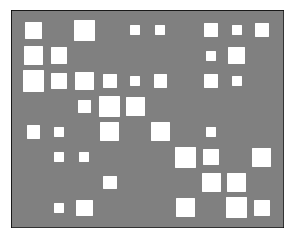

In [9]:
hinton(np.array(utility_matrix).T)

In [6]:
utility_matrix.columns

Index([u'2054145', u'1435307', u'575830', u'808966', u'2297863', u'2222089',
       u'327691', u'752642', u'1706000', u'1648657'],
      dtype='object')